In [506]:
# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from catboost import CatBoostRegressor
from sklearn.svm import SVC


In [476]:
train = pd.read_csv('/home/saule/ds_bootcamp/Light_GBM/Data/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [477]:
test = pd.read_csv('/home/saule/ds_bootcamp/Light_GBM/Data/test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [387]:
train.groupby('BsmtQual')['SalePrice'].mean()

BsmtQual
Ex    327041.041322
Fa    115692.028571
Gd    202688.478964
TA    140759.818182
Name: SalePrice, dtype: float64

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

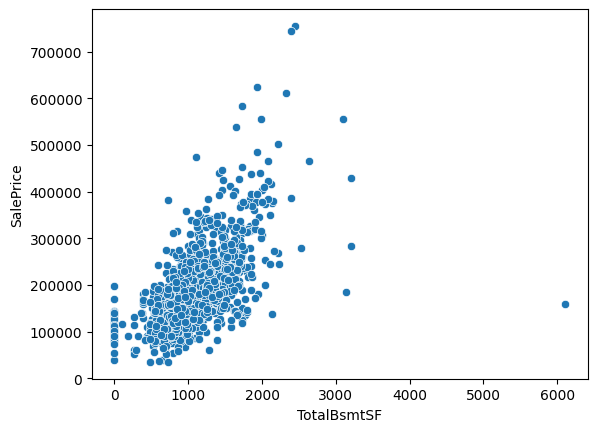

In [388]:
sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice')

In [389]:
train['TotalBsmtSF'].describe()

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

In [390]:
filtered_train = train[train['TotalBsmtSF'] <= 2500]
filtered_train['TotalBsmtSF'].describe()                   # удалить выбросы по площади подвала

count    1453.000000
mean     1046.071576
std       400.387268
min         0.000000
25%       795.000000
50%       990.000000
75%      1288.000000
max      2444.000000
Name: TotalBsmtSF, dtype: float64

In [391]:
train_copy = train.copy()

In [392]:
X, y = train.drop('SalePrice', axis=1), train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=None, random_state=42)

In [393]:
# Функция для замены значений "NA" на 0
def replace_na_with_zero(column):
     return column.replace({'NA': 'No', 'nan': 'No', 'None': 'No', np.nan: 'No'})

In [394]:
drop_features = ['Id'] # Эти столбцы считаем не нужными и выкидываем
na_to_zero_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'] 


my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', drop_features),
        ('replace_na', FunctionTransformer(replace_na_with_zero), na_to_zero_columns),
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), ['Electrical'])
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)    

In [395]:
filled_data = my_imputer.fit_transform(train)
train_copy = my_imputer.fit_transform(train_copy)

In [396]:
filled_data['BsmtQual'].isna().sum()

0

In [398]:
custom_encoding_columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical']

category_mapping = {
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'BsmtExposure': {'Gd': 5, 'Av': 4, 'Mn': 3, 'No': 2, 'NA': 1},
    'ExterQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'ExterCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'BsmtFinType1': {'GLQ': 3, 'ALQ': 2, 'BLQ': 1, 'Rec': 1, 'LwQ': 1, 'Unf': 2, 'No': 0},
    'BsmtFinType2': {'GLQ': 3, 'ALQ': 2, 'BLQ': 1, 'Rec': 1, 'LwQ': 1, 'Unf': 2, 'No': 0},
    'Heating': {'Floor': 0, 'Grav': 0, 'Wall': 1, 'OthW': 2, 'GasW': 3, 'GasA':4},
    'HeatingQC': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'Electrical': {'Mix': 0, 'FuseP': 1, 'FuseF': 2, 'FuseA': 3, 'SBrkr': 4}
}

def custom_encode(df):
    for column in df.columns:
        if column in category_mapping:
            df[column] = df[column].map(category_mapping[column])
    return df

In [399]:
ordinal_encoding_columns = ['Foundation']
standard_scaler_columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']
one_hot_encoding_columns = ['CentralAir']

scaler_and_encoder = ColumnTransformer(
    [
        ('custom_encoding', FunctionTransformer(custom_encode), custom_encoding_columns),
        ('one_hot_encoding_columns', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling_num_columns', StandardScaler(), standard_scaler_columns)    
   
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

In [400]:
train.groupby('BsmtExposure')['SalePrice'].mean()

BsmtExposure
Av    206643.420814
Gd    257689.805970
Mn    192789.657895
No    165652.295908
Name: SalePrice, dtype: float64

In [401]:
filled_data.groupby('BsmtExposure')['SalePrice'].mean()

BsmtExposure
Av    206643.420814
Gd    257689.805970
Mn    192789.657895
No    163439.248234
Name: SalePrice, dtype: float64

In [402]:
filled_data['BsmtQual'].value_counts()

BsmtQual
TA    649
Gd    618
Ex    121
No     37
Fa     35
Name: count, dtype: int64

### from main

In [478]:
train['SalePrice'] = np.log(train['SalePrice'])


In [479]:
X, y = train.drop('SalePrice', axis=1), train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=None, random_state=42)

In [480]:
# Функция для замены значений "NA" на 0
def replace_na_with_zero(column):
     return column.fillna("No") # np.nan


In [481]:
train['BsmtQual'].isna().sum()

37

In [520]:
# Удаляем неинформативные колонки
drop_features = ['Id', 'Alley', 'MasVnrType', 'Utilities', 'RoofMatl', "SaleType","YrSold","MiscVal",\
                 "3SsnPorch","MoSold","FireplaceQu","MiscFeature","PoolArea"] # Alley - тип доступа в переулок (94% пропусков),
# MasVnrType - тип каменной облицовки (59% пропусков)
nan_columns = ['FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
na_to_zero_columns = ['BsmtQual', 'BsmtCond']

my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', drop_features),
        ('num_imputer', SimpleImputer(strategy='median'), ['LotFrontage','MasVnrArea']), # LotFrontage - погонные футы улицыБ соединенные с участком (17% пропусков),
        # MasVnrArea - площадь каменного шпона в квадратных футах
        ('replace_na', FunctionTransformer(replace_na_with_zero), na_to_zero_columns),
        ('nan_fill', SimpleImputer(strategy='constant', fill_value='No'), nan_columns), #Заполняем NaN значением No, чтобы кодировались
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), ['Electrical','GarageYrBlt'])
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' )

In [483]:
# Передаем данные в модель
filled_data = my_imputer.fit_transform(X_train)

In [484]:
# Для кастомного encoding

custom_encoding_columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical']

category_mapping = {
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'BsmtExposure': {'Gd': 5, 'Av': 4, 'Mn': 3, 'No': 2, 'NA': 1},
    'ExterQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'ExterCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'BsmtFinType1': {'GLQ': 3, 'ALQ': 2, 'BLQ': 1, 'Rec': 1, 'LwQ': 1, 'Unf': 2, 'No': 0},
    'BsmtFinType2': {'GLQ': 3, 'ALQ': 2, 'BLQ': 1, 'Rec': 1, 'LwQ': 1, 'Unf': 2, 'No': 0},
    'Heating': {'Floor': 0, 'Grav': 0, 'Wall': 1, 'OthW': 2, 'GasW': 3, 'GasA':4},
    'HeatingQC': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'Electrical': {'Mix': 0, 'FuseP': 1, 'FuseF': 2, 'FuseA': 3, 'SBrkr': 4}
}

def custom_encode(df):
    for column in df.columns:
        if column in category_mapping:
            df[column] = df[column].map(category_mapping[column])
    return df

In [485]:
ordinal_encoding_columns = ['Foundation', 'KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PoolQC', \
                           'MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'BldgType', 'HouseStyle',\
                           'RoofStyle','Neighborhood','Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd']
standard_scaler_columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd',\
                           'Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF', 'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',\
                           'PoolArea','MiscVal','MoSold','YrSold']
one_hot_encoding_columns = ['CentralAir', 'GarageType','PavedDrive','Fence','MiscFeature','SaleType','SaleCondition']


scaler_and_encoder = ColumnTransformer(
    [
        ('custom_encoding', FunctionTransformer(custom_encode), custom_encoding_columns),
        ('one_hot_encoding_columns', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling_num_columns', StandardScaler(), standard_scaler_columns),
        ('ordinal_encoding', OrdinalEncoder(), ordinal_encoding_columns)
   
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

In [503]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder)
    ]
)

In [487]:
filled_data = preprocessor.fit_transform(train)

In [488]:
check_nan = pd.DataFrame(data={'NaN_count': filled_data.isna().sum(), 'data_type':filled_data.dtypes})
check_nan.loc[check_nan["NaN_count"]>0]

,NaN_count,data_type
BsmtQual,37,float64
BsmtCond,37,float64


In [489]:
selected_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'SalePrice']
filled_data_new = filled_data[selected_columns]

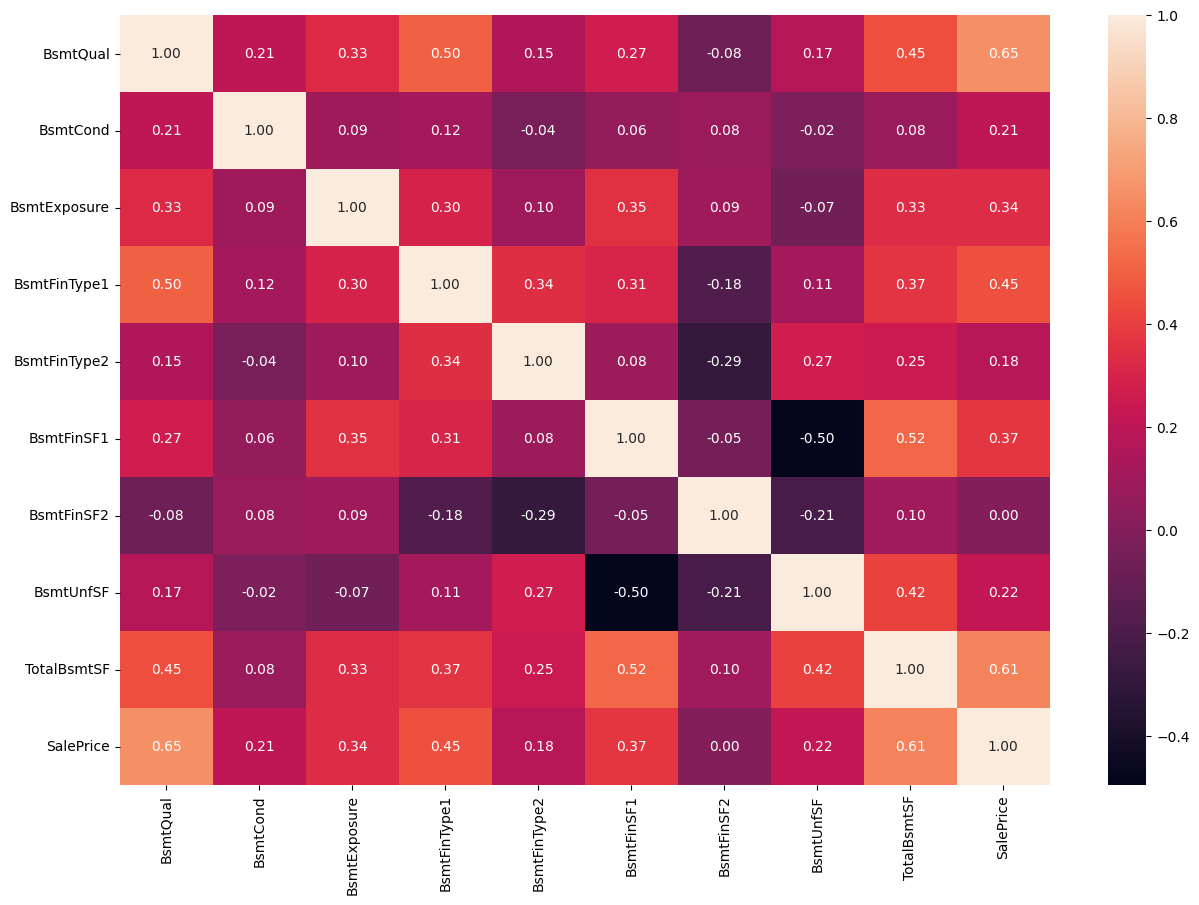

In [490]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(filled_data_new.corr(),  annot=True, fmt='.2f');

In [491]:
selected_columns_2 = ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','SalePrice']
filled_data_new_2 = filled_data[selected_columns_2]

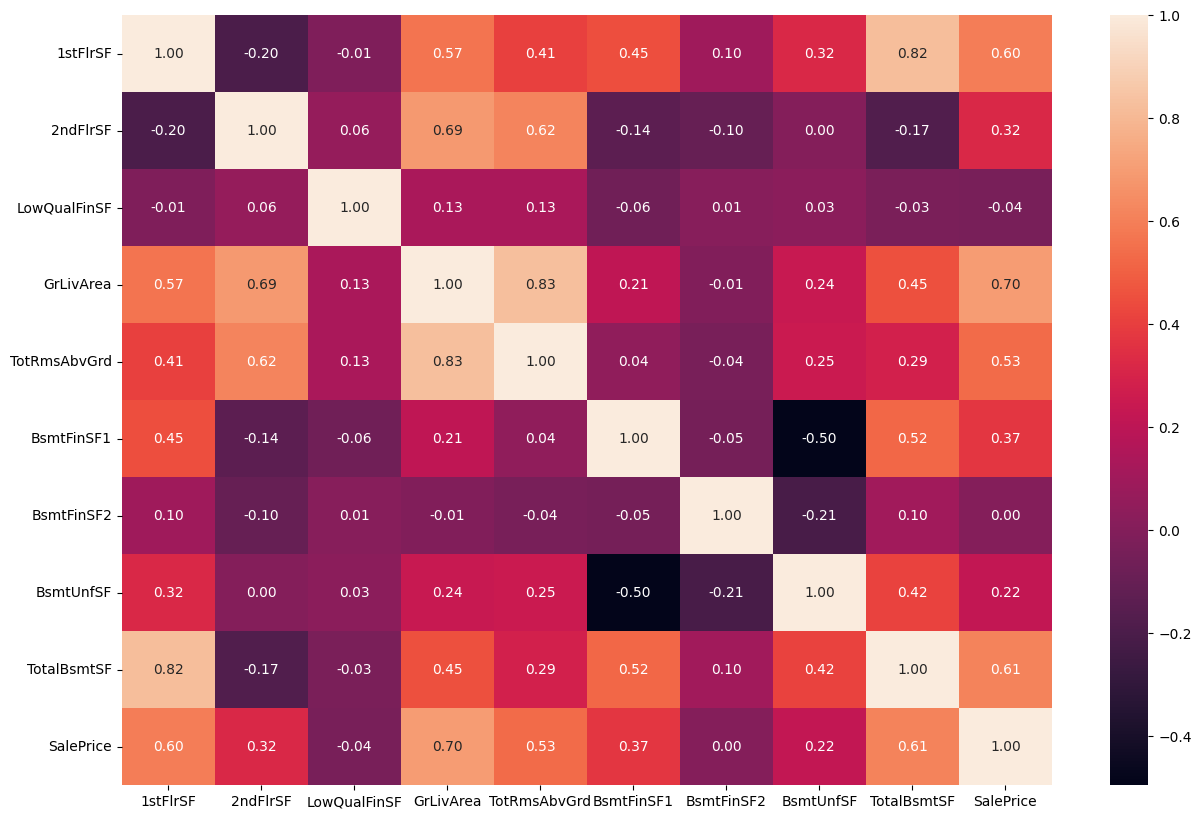

In [492]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(filled_data_new_2.corr(),  annot=True, fmt='.2f');

In [500]:
floor_1 = ['1stFlrSF', 'TotalBsmtSF']
floor_2 = ['2ndFlrSF', 'TotRmsAbvGrd', 'GrLivArea']

In [502]:
floor_1_pca = PCA(n_components=1)
floor_2_pca = PCA(n_components=1)

In [515]:
# Определение преобразований для каждого набора столбцов
pca_transformers = [
    ('floor_1_pca', floor_1_pca, floor_1),
    ('floor_2_pca', floor_2_pca, floor_2),
]# Создание ColumnTransformer с PCA преобразованиями
pca_column_transformer = ColumnTransformer(
    transformers=pca_transformers,
    remainder='passthrough'
)

In [516]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder),
        ('pca', pca_column_transformer)
    ]
)

In [517]:
filled_data = preprocessor.fit_transform(train)

In [519]:
preprocessor

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['Id', 'Alley', 'MasVnrType',
                                                   'Utilities', 'RoofMatl']),
                                                 ('num_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['LotFrontage',
                                                   'MasVnrArea']),
                                                 ('replace_na',
                                                  FunctionTransformer(func=<function replace_na_with_zero at 0x7b0b5b2b4820>),
                                                  ['BsmtQual', 'BsmtCond']),
                                                 (...
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'Exterior1st',
                                                   'Exterior2nd'])],
                                   verbose_feature_names_out=False)),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('floor_1_pca',
                                                  PCA(n_components=1),
                                                  ['1stFlrSF', 'TotalBsmtSF']),
                                                 ('floor_2_pca',
                                                  PCA(n_components=1),
                                                  ['2ndFlrSF', 'TotRmsAbvGrd',
                                                   'GrLivArea'])]))])

In [461]:
selected_columns_3 = ['Heating', 'HeatingQC', 'Electrical','SalePrice']
filled_data_new_3 = filled_data[selected_columns_3]

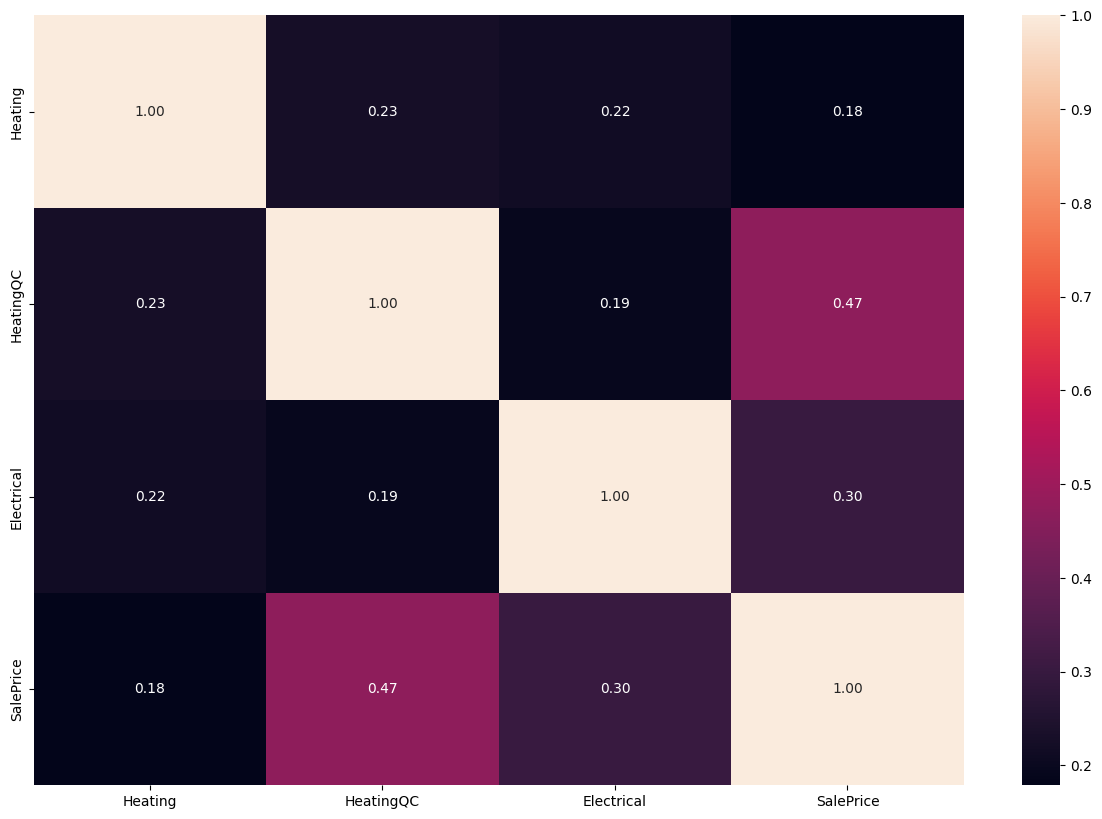

In [462]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(filled_data_new_3.corr(),  annot=True, fmt='.2f');

In [463]:
ordinal_encoding_columns = ['Foundation', 'KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PoolQC', \
                           'MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'BldgType', 'HouseStyle',\
                           'RoofStyle','Neighborhood','Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd', \
                           'ExterQual', 'ExterCond', 'BsmtExposure', 'BsmtFinType1',\
                            'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical']
standard_scaler_columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd',\
                           'Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF', 'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',\
                           'PoolArea','MiscVal','MoSold','YrSold']
one_hot_encoding_columns = ['CentralAir', 'GarageType','PavedDrive','Fence','MiscFeature','SaleType','SaleCondition']


scaler_and_encoder = ColumnTransformer(
    [
      #  ('custom_encoding', FunctionTransformer(custom_encode), custom_encoding_columns),
        ('one_hot_encoding_columns', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling_num_columns', StandardScaler(), standard_scaler_columns),
        ('ordinal_encoding', OrdinalEncoder(), ordinal_encoding_columns)
   
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

In [464]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder)
    ]
)

In [467]:
selected_columns_3 = ['Heating', 'HeatingQC', 'Electrical','SalePrice']
filled_data_new_3 = filled_data[selected_columns_3]

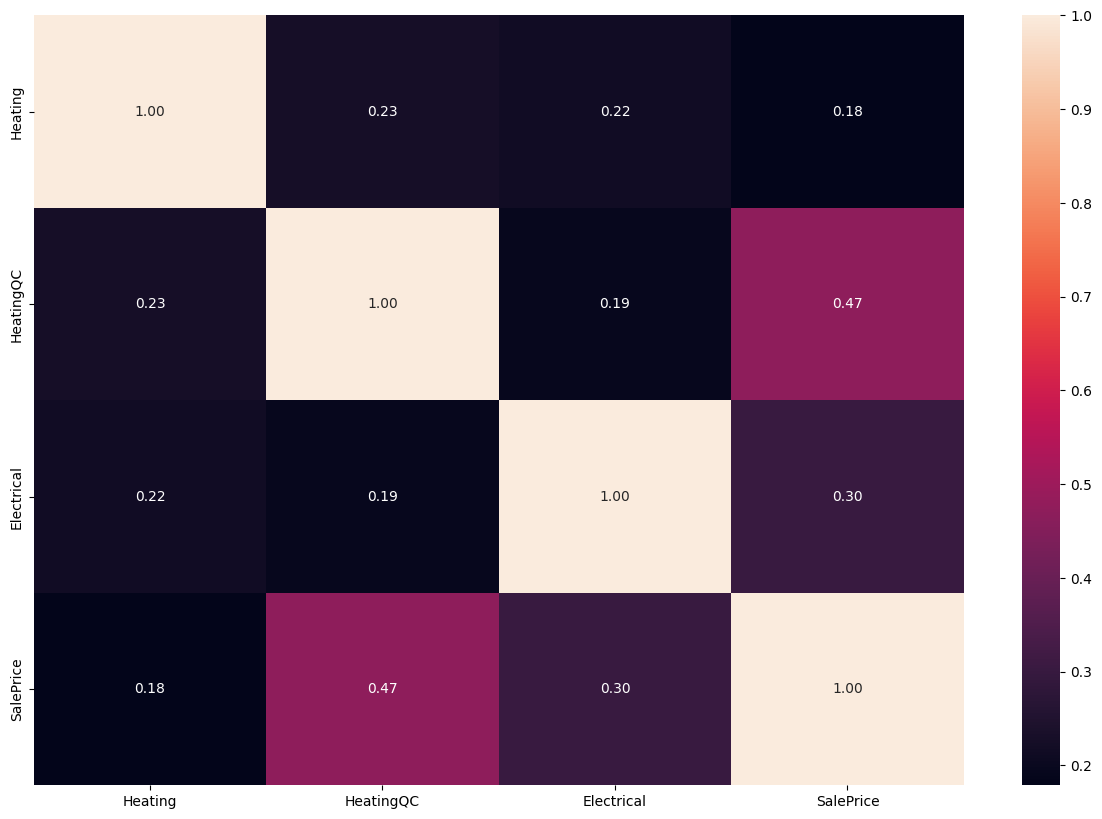

In [468]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(filled_data_new_3.corr(),  annot=True, fmt='.2f');